In [1]:
import os
import numpy as np
import pandas as pd
from collections import defaultdict

In [2]:
import sys
sys.path.append('../../Python/')
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from Preprocessing import standardize, MaxMinScaler
from Evaluation import split_train_test_ma, train_model, test_model
from Databases import get_databases_path, get_database

In [3]:
def diff1(l, s, Nfre, N):
    epsilon = (0.03*N)/Nfre
    return (l-s) < epsilon 

# Function to Estimate the Threshold
def estimateThreshold(Freq_Table, Nfre, Frepos, N):
    maximaset = [1]
    minimaset = [1]
             
    table_keys = list(Freq_Table.keys())
    for idx in range(1, len(table_keys)-1):
        a = Freq_Table[table_keys[idx]]['Count'] - Freq_Table[table_keys[idx-1]]['Count'] 
        b = Freq_Table[table_keys[idx+1]]['Count'] - Freq_Table[table_keys[idx]]['Count'] 
        
        c1 = diff1(Frepos[idx], Frepos[(minimaset[-1])], Nfre, N)
        if a >=0 and b<=0 and c1:
            maximaset.append(idx)
        
        c2 = diff1(Frepos[(maximaset[-1])], Frepos[idx], Nfre, N)
        if a <=0 and b>=0 and c2:
            minimaset.append(idx)
    
    # First Part
    aux = np.zeros(len(maximaset))

    for idx, val in enumerate(maximaset):
        if Frepos[val] < 0.5:
            range_index = str(round(Frepos[val],1))
            aux[idx] = Freq_Table[range_index]['Count']
        else: 
            aux[idx] = 0;
    
    if aux.sum() == 0:
        P1 = None
    else:
        amax = np.argmax(aux)
        P1 = maximaset[amax]
        fP1 = Frepos[P1]
     
    # Second Part
    aux = np.zeros(len(maximaset))
    for idx, val in enumerate(maximaset):
        if Frepos[val] > fP1:
            range_index = str(round(Frepos[val],1))
            aux[idx] = Freq_Table[range_index]['Count']
        else: 
            aux[idx] = 0;

    if aux.sum() == 0:
        P2 = None
    else:
        amax = np.argmax(aux)
        P2 = maximaset[amax]
        fP2 = Frepos[P2]
        
    if P1 is not None and P2 is not None:
        if not minimaset:
            valley = [];
        else:
            aux = np.zeros(len(minimaset))
            for idx, val in enumerate(minimaset):
                if Frepos[val] > fP1 and Frepos[val] < fP2:
                    range_index = str(round(Frepos[val],1))
                    aux[idx] = Freq_Table[range_index]['Count']
                else: 
                    aux[idx] = 0
            
            if aux.sum() == 0:
                valley = []
            else:
                amax = np.argmax(aux)
                valley = maximaset[amax]
                fvalley = Frepos[valley]
    else:
        valley = [];
        
    if not valley:
        t = P1
    else:
        t = valley
    
    Nl = 0

    for idx in range(0,t):
        Nl += Freq_Table[table_keys[idx]]['Count']

    while Nl < N/2:
        t += 1;
        Nl += Freq_Table[table_keys[t]]['Count']

    Nr = N - Nl
    return t, Nl, Nr

def get_ground_truth(y_train):
    y_train_set = y_train.copy(deep=True)
    R = y_train_set.columns.size
    N = y_train_set.shape[0]

    step = 1/R
    Frepos = np.round(np.arange(0, 1+step, step),decimals=2)
    Nfre = len(Frepos)
    
    # Create an object to store all variables
    Freq_Table = {}
    for key in Frepos:
        index = str(round(key,1))
        Freq_Table[index] = {}
        Freq_Table[index]['Count'] = 0
        Freq_Table[index]['Items'] = []
        Freq_Table[index]['Cat'] = 0
    table_keys = list(Freq_Table.keys())
    
    # Count True Labels throught all anotators
    for idx, row in y_train_set.iterrows():
        fi = round(row[row == True].sum()/R,1)
        index = str(round(fi,1))
        Freq_Table[index]['Count'] += 1
        Freq_Table[index]['Items'].append(idx)
        
    t, Nl, Nr = estimateThreshold(Freq_Table, Nfre, Frepos, N)

    Pmax = (Nl - Nr)*Nr/(Nl + Nr) + Nr;
    k = Nfre-1;
    Np = 0;

    while k >= t:
        Freq_Table[table_keys[k]]['Cat'] = 1;
        Np += Freq_Table[table_keys[k]]['Count']
        k -= 1
        
    fm = (Frepos[0] + Frepos[t])*0.5
    k = t
    while (Frepos[k] > fm) and (Np + Freq_Table[table_keys[k]]['Count'] < Pmax):
        Freq_Table[table_keys[k]]['Cat'] = 1
        Np += Freq_Table[table_keys[k]]['Count']
        k -= 1
    
    for idx in range(0,Nfre):
        aux = Freq_Table[table_keys[idx]]['Items'];
        y_train_set.loc[aux, 'yHat'] = Freq_Table[table_keys[idx]]['Cat']
        
    yHat = y_train_set[['yHat']].astype('bool')
    
    return yHat

------------------------------------------------------------------------
Database: ../../Databases/Sinteticas/breast-cancer 


Results

-- Global Precision --
0.8771929824561403


-- General Report --
              precision    recall  f1-score   support

         yes       0.87      0.94      0.91       108
          no       0.89      0.76      0.82        63

    accuracy                           0.88       171
   macro avg       0.88      0.85      0.86       171
weighted avg       0.88      0.88      0.87       171



-- Confusion Matrix --
     0   1
0  102   6
1   15  48

ROC Curve: 

ROC AUC:  0.9425338036449147


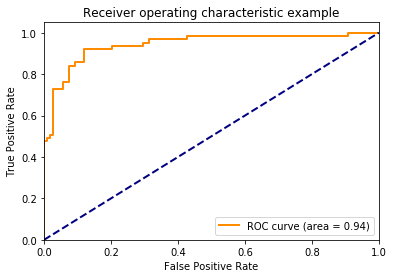

------------------------------------------------------------------------
Database: ../../Databases/Sinteticas/column 


Results

-- Global Precision --
0.6666666666666666


-- General Report --
              precision    recall  f1-score   support

         yes       0.88      0.59      0.70        63
          no       0.49      0.83      0.62        30

    accuracy                           0.67        93
   macro avg       0.69      0.71      0.66        93
weighted avg       0.75      0.67      0.68        93



-- Confusion Matrix --
    0   1
0  37  26
1   5  25

ROC Curve: 

ROC AUC:  0.7814814814814817


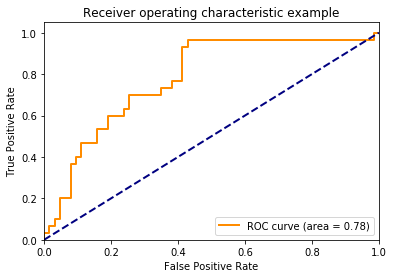

------------------------------------------------------------------------
Database: ../../Databases/Sinteticas/parkinsons 


Results

-- Global Precision --
0.8813559322033898


-- General Report --
              precision    recall  f1-score   support

         yes       0.90      0.96      0.93        46
          no       0.80      0.62      0.70        13

    accuracy                           0.88        59
   macro avg       0.85      0.79      0.81        59
weighted avg       0.88      0.88      0.88        59



-- Confusion Matrix --
    0  1
0  44  2
1   5  8

ROC Curve: 

ROC AUC:  0.8762541806020067


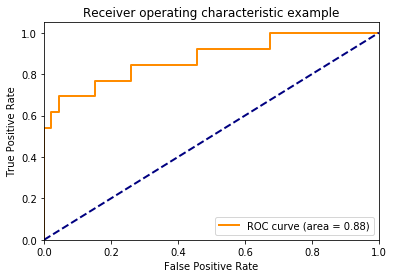

------------------------------------------------------------------------
Database: ../../Databases/Sinteticas/ionophere 


Results

-- Global Precision --
0.3523809523809524


-- General Report --
              precision    recall  f1-score   support

         yes       0.35      1.00      0.52        37
          no       0.00      0.00      0.00        68

    accuracy                           0.35       105
   macro avg       0.18      0.50      0.26       105
weighted avg       0.12      0.35      0.18       105



-- Confusion Matrix --
    0  1
0  37  0
1  68  0

ROC Curve: 

ROC AUC:  0.766295707472178


/Users/codigoriginal/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


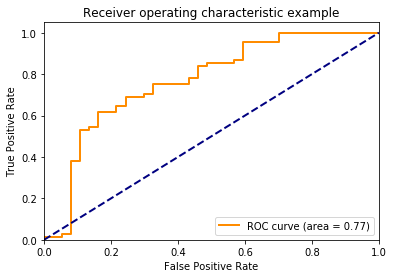

------------------------------------------------------------------------
Database: ../../Databases/Sinteticas/sentiment-polarity 


Results

-- Global Precision --
0.5428571428571428


-- General Report --
              precision    recall  f1-score   support

         yes       0.50      0.94      0.65        48
          no       0.80      0.21      0.33        57

    accuracy                           0.54       105
   macro avg       0.65      0.57      0.49       105
weighted avg       0.66      0.54      0.48       105



-- Confusion Matrix --
    0   1
0  45   3
1  45  12

ROC Curve: 

ROC AUC:  0.6695906432748537


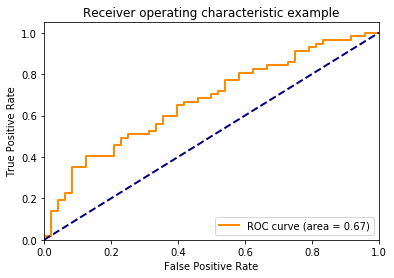

In [4]:
databases_path = '../../Databases/Sinteticas'
paths = get_databases_path(databases_path)

for database in paths:
    print('------------------------------------------------------------------------')
    print("Database:", database, '\n')

    # Obtain the attributes and labels
    attr_df = get_database(database, 'database_attr.csv')
    labels_df = get_database(database, 'database_labels.csv') 

    attr_df = MaxMinScaler(attr_df)

    # Split in Training and Test Sets
    X_train, X_test, y_train, y_test = split_train_test_ma(attr_df, labels_df)

    # Get the Ground Thruth
    yHat = get_ground_truth(y_train)

    # Train PLAT Model
    model = train_model(X_train, yHat)

    # Test PLAT Model
    print("\nResults\n")
    test_model(model, X_test, y_test)